# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [2]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
from transformers import AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
from transformers import AutoTokenizer
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.nn.functional import cross_entropy
from huggingface_hub import notebook_login

import torch
import torch.nn.functional as F
import os
import collections
import re
import emoji
import string
import copy

/home/penscola/anaconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/penscola/anaconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/penscola/anaconda3/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepreca

In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Load the dataset and display some values
df = pd.read_csv('../data/Train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


In [5]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [6]:
# check the datatype of the data and its total rows or rather the total number of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   9999 non-null   object 
 1   safe_text  9999 non-null   object 
 2   label      9999 non-null   float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [7]:
df.columns

Index(['tweet_id', 'safe_text', 'label', 'agreement'], dtype='object')

In [8]:
# see all unique values in every column in df dataset
for column in df.columns:
    print(column, ":", df[column].nunique())

tweet_id : 9999
safe_text : 9656
label : 3
agreement : 3


In [9]:
# Check for missing values
df.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [10]:
#look at some of the tweets and how they are written
for tweet in range(10):
    tweet_str=df['safe_text'][tweet]
    print(f'{tweet_str}\n')

Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>

I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day

#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD

I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that

Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>

<user> a nearly 67 year old study when mental health studies and vaccines were relatively in their infancies that has been refuted?

Study of more than 95,000 kids finds no link between MMR vaccine and autism <url>

psa: VACCINATE YOUR FUCKING KIDS

Coughing extra on the shuttle and everyone thinks I have the measles. 😂 #VaccinateYourKids

AIDS vaccine created at Oregon Health &amp; Science University may clear virus from body - <url> <url>



## Findings
- Some tweets contain hashtags, others contain numbers while others contain plain text

- usernames have been replaced with < user > while links have been replaced with < url >

## Exploratory Data analysis
1. Use wordcloud to look at the most words appearing
2. Check for emojis
3. Most used words

## Visualize frequent words using wordcloud

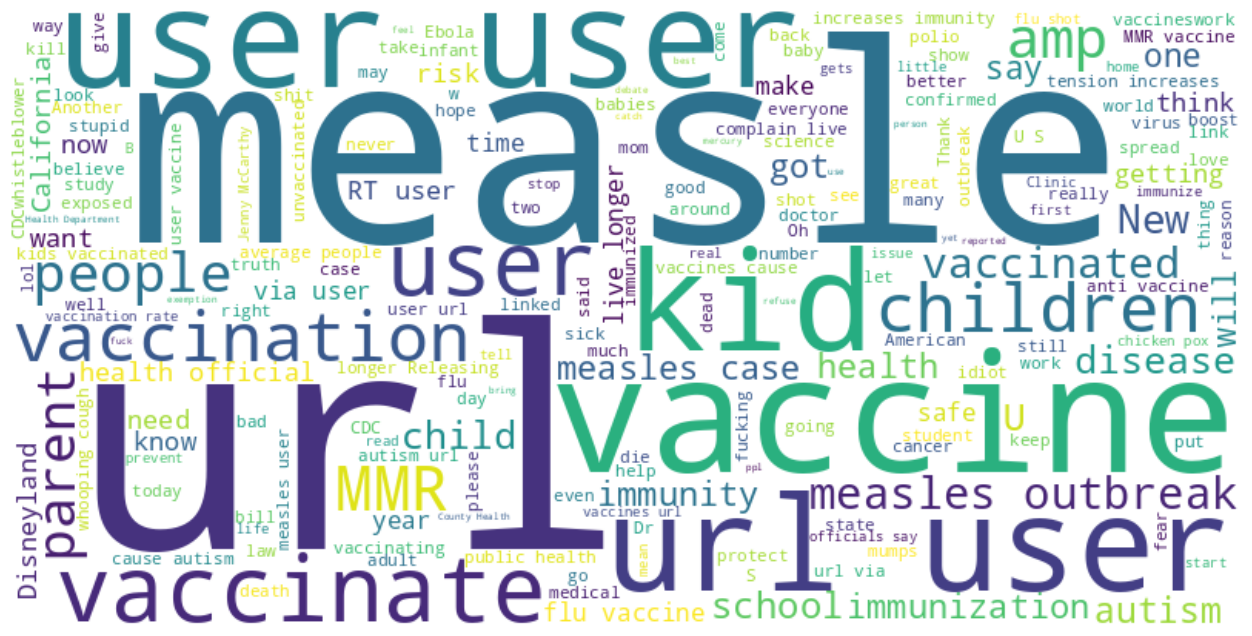

In [11]:
# Generate a word cloud from the message text data
text = " ".join(tweet for tweet in df.safe_text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### User and Url won't be relevant to our analysis so lets remove them

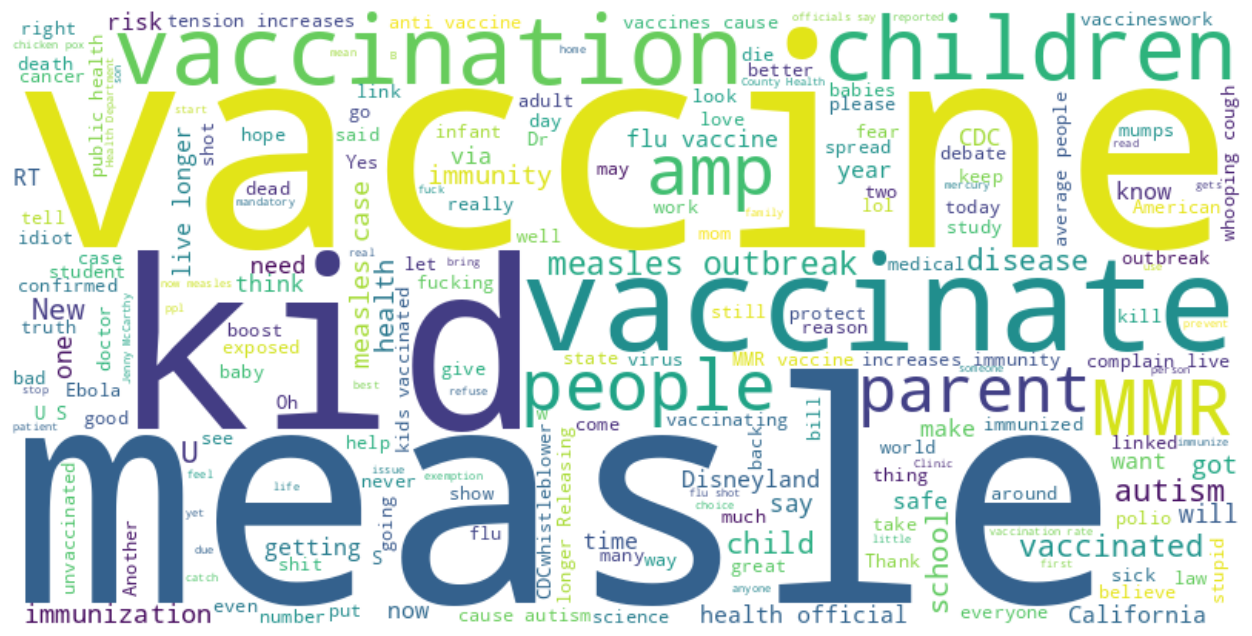

In [12]:
#replace user,url in the df
df['safe_text']=df['safe_text'].replace({'user':'','url':''},regex=True)


# regenerate wordcloud
text = " ".join(tweet for tweet in df.safe_text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looks like the the vaccination is for measles and parents might be worried about their kids. This is why we should understand the sentiment in each tweet to how parents feel about this vaccination.

### Let's check word Frequency again using barcharts

In [13]:
# Combine all tweets
tweets = " ".join(df['safe_text'].astype(str))

# Split the string into a list of words ignoring special characters
words = re.findall(r'\b\w+\b', tweets)

# Convert all words to lowercase
words = [word.lower() for word in words]

# Count the occurrences of each word using Counter
word_counts = collections.Counter(words)

# Combine words that differ only with 's' at the end
combined_words = []
for word in words:
    if word.endswith('s') and len(word) > 1:
        singular_word = word[:-1]
        if singular_word in word_counts:
            combined_words.append(singular_word)
        else:
            combined_words.append(word)
    else:
        combined_words.append(word)

# Recount the occurrences of each word using Counter
word_counts = collections.Counter(combined_words)

# Get the top 20 most common words and their counts
top_words = dict(word_counts.most_common(20))

top_words

{'the': 4138,
 'i': 3858,
 'to': 3682,
 'measle': 3575,
 'vaccine': 3031,
 'a': 2871,
 'of': 2359,
 'in': 2181,
 'and': 2007,
 'for': 1612,
 'kid': 1466,
 't': 1419,
 's': 1402,
 'you': 1333,
 'it': 1228,
 'health': 1159,
 'that': 1109,
 'your': 1081,
 'vaccination': 1073,
 'mmr': 1023}

### Visualize word frequency using bar chart

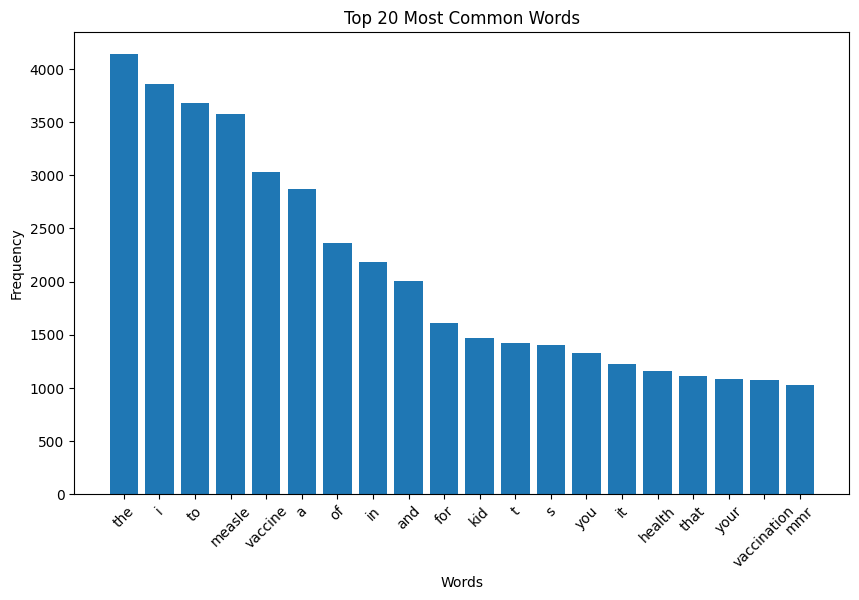

In [14]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

### Check for the presence of Emojis: Emojis are a fundamental part of tweeting today

In [15]:
 #Function to extract all emojis from a text
def extract_emojis(tweet):
    return ''.join(E for E in tweet if E in emoji.EMOJI_DATA)


# Extract all emojis from the message text data
emojis = extract_emojis(tweets)

- As expected we do have some emojis in our text
- We can decide to fine tune algorithms that can handle emojis

In [16]:
# Create a list of all the extracted emojis
emojis_list = list(emojis)

# Count the frequency of each emoji in the list
emoji_dict = dict(collections.Counter(emojis_list))

# Sort the dictionary in descending order of frequency
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

# Convert the dictionary to a pandas DataFrame
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

# Display the top 20 most frequently used emojis
print(emoji_df.head(10))

  emoji  count
0     😂    140
1     💉     63
2     😷     58
3     🔥     52
4     😭     40
5     😳     39
6     💥     30
7     😒     29
8     🙌     27
9     👏     25


* The most frequently used emoji is 😂 with a count of 140. This emoji is commonly associated with laughter or amusement.

* The second most frequently used emoji is 💉 with a count of 63. This emoji represents a syringe and is often used in the context of healthcare, vaccinations, or medical topics.

* The third most frequently used emoji is 😷 with a count of 58. This emoji depicts a face wearing a medical mask and is commonly used to represent sickness, health precautions, or protection.

### Visualize the top 10 most use

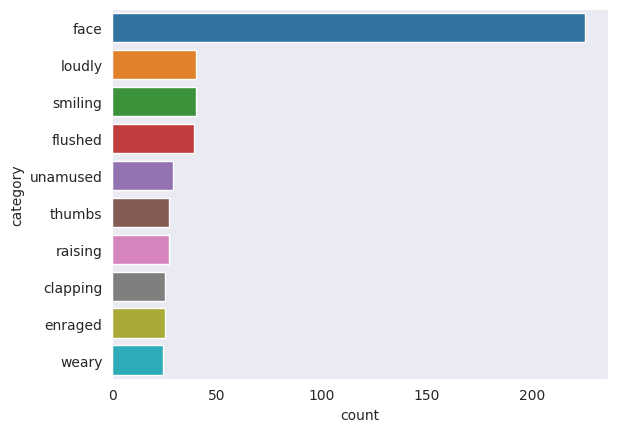

In [17]:
# Group the emojis by category
emoji_dict = collections.defaultdict(int)
for emoji_char in emojis_list:
    emoji_desc = emoji.demojize(emoji_char, delimiters=("", ""))
    emoji_desc_parts = emoji_desc.split("_")
    if len(emoji_desc_parts) > 1:
        emoji_category = emoji_desc_parts[0]
        emoji_dict[emoji_category] += 1

# Convert the dictionary to a pandas DataFrame
emoji_df = pd.DataFrame(emoji_dict.items(), columns=['category', 'count'])

# Sort the DataFrame by frequency count in descending order
emoji_df = emoji_df.sort_values(by='count', ascending=False)

# Select the top 10 rows
top_10_emojis = emoji_df.head(10)
sns.set_style('dark')
sns.barplot(x='count',y='category',data=emoji_df.head(10));

### Distribution of Sentiment Labels

In [18]:
# Calculate the frequency of each sentiment label
label_counts = df['label'].value_counts()
label_counts

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

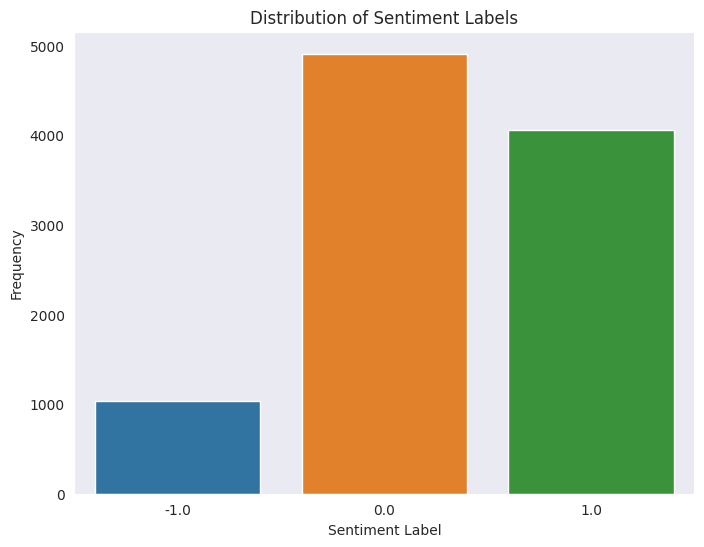

In [19]:
df['label'] = df['label'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.show()

**The labels are not perfectly balanced, as there is some variation in the frequencies. However, the difference between the frequencies of the labels is not extremely large, which suggests a relatively balanced distribution.**

### To perform text length analysis on the "safe_text" column

In [20]:
# Calculate the length of each text in the "safe_text" column
text_lengths = df['safe_text'].apply(len)

# Compute descriptive statistics of text lengths
text_length_stats = text_lengths.describe()

# Print the descriptive statistics
print(text_length_stats)

count    9999.000000
mean       96.291029
std        30.083376
min         3.000000
25%        75.000000
50%       103.000000
75%       119.000000
max       153.000000
Name: safe_text, dtype: float64


### Visualize the distribution of text lengths using histograms or box plots.

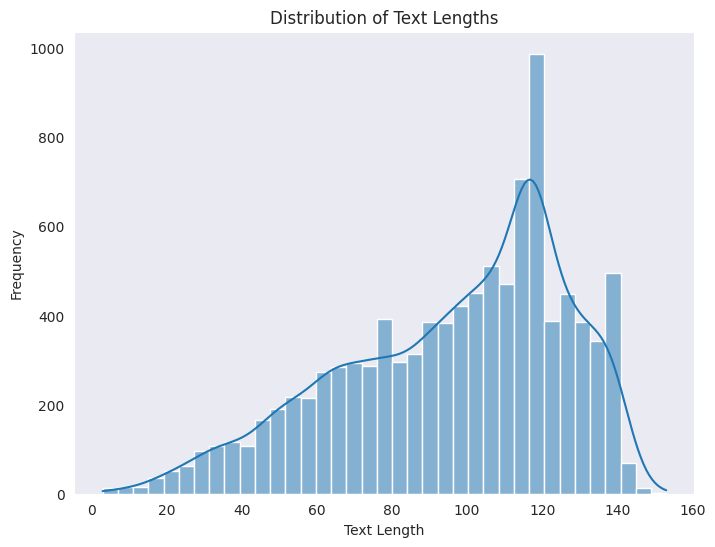

In [21]:
# Create a histogram to visualize the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

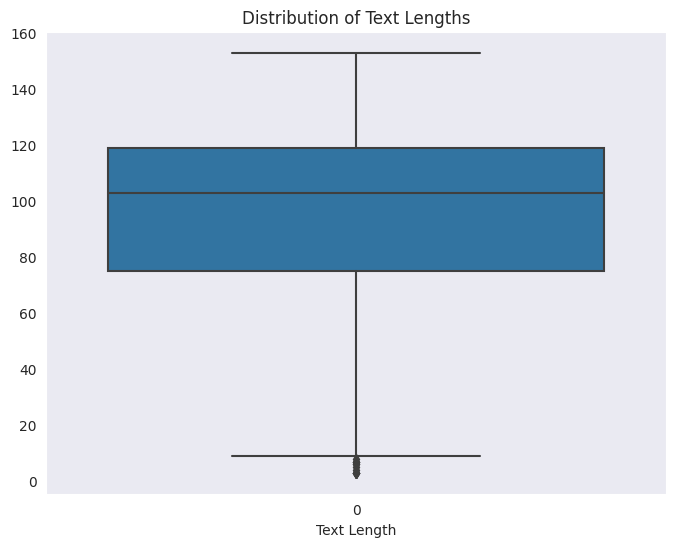

In [22]:
# Create a box plot to visualize the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.boxplot(text_lengths)
plt.xlabel('Text Length')
plt.title('Distribution of Text Lengths')
plt.show()

### Perform agreement analysis on the data

In [23]:
# Calculate descriptive statistics for the "agreement" column
agreement_mean = df['agreement'].mean()
agreement_median = df['agreement'].median()
agreement_std = df['agreement'].std()

# Print the results
print("Agreement Mean:", agreement_mean)
print("Agreement Median:", agreement_median)
print("Agreement Standard Deviation:", agreement_std)

Agreement Mean: 0.8542520918758542
Agreement Median: 1.0
Agreement Standard Deviation: 0.1807071980577538


### Visualize the distribution of the "agreement" values using a histogram:

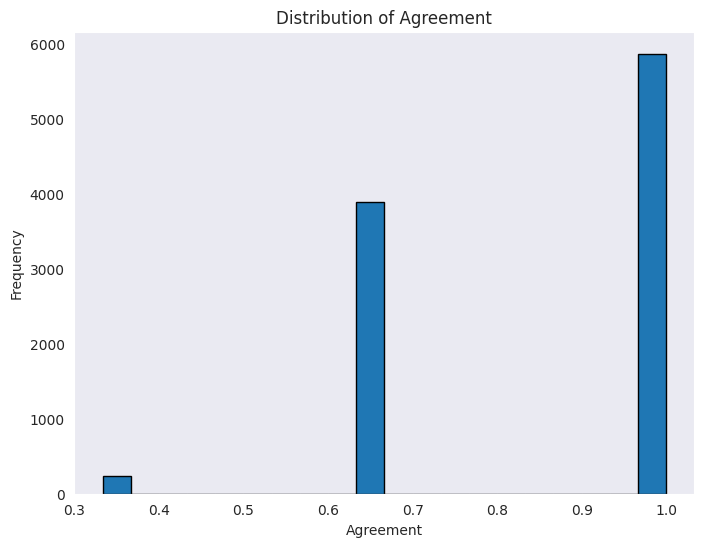

In [24]:
# Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['agreement'], bins=20, edgecolor='black')
plt.xlabel('Agreement')
plt.ylabel('Frequency')
plt.title('Distribution of Agreement')
plt.show()

### Visualize the distribution of the "agreement" values using a box plot:

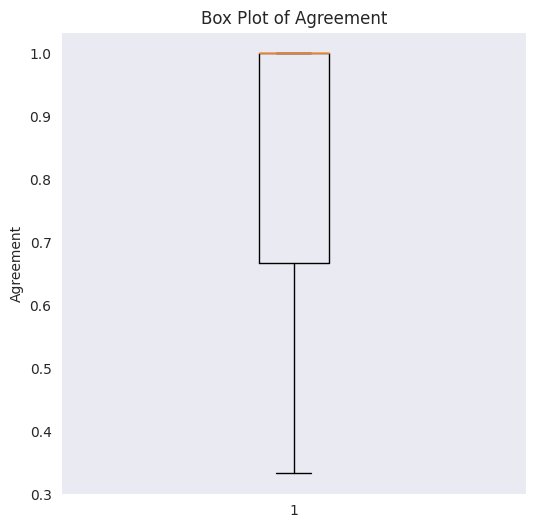

In [25]:
# Plot a box plot
plt.figure(figsize=(6, 6))
plt.boxplot(df['agreement'])
plt.ylabel('Agreement')
plt.title('Box Plot of Agreement')
plt.show()

Overall, the high mean and median agreement values, along with the low standard deviation, suggest a generally high level of consensus among annotators in the sentiment annotations. This is a positive indication for the reliability and consistency of the sentiment labels in the dataset.

### Counting the sentiment labels within each agreement level category

In [26]:
# Counting the sentiment labels within each agreement level category
label_counts = df.groupby('agreement')['label'].value_counts()

# Printing the label counts for each agreement level category
for agreement, counts in label_counts.groupby(level=0):
    print(f"Agreement Level: {agreement}")
    print(counts)
    print('\n')

Agreement Level: 0.3333333333333333
agreement  label
0.333333   -1.0     239
           0.0        0
           1.0        0
Name: label, dtype: int64


Agreement Level: 0.6666666666666666
agreement  label
0.666667   0.0      1748
           1.0      1729
           -1.0      417
Name: label, dtype: int64


Agreement Level: 1.0
agreement  label
1.0        0.0      3160
           1.0      2324
           -1.0      382
Name: label, dtype: int64




These results show the count of sentiment labels within each agreement level category. It appears that the majority of tweets with an agreement level of 0.6666666666666666 have both neutral and positive sentiment labels, while the agreement level of 1.0 has a higher count of neutral sentiment labels compared to negative and positive sentiments. On the other hand, the agreement level of 0.3333333333333333 primarily consists of negative sentiment labels.

### Visualize the distribution of sentiment labels based on the agreement level among annotators

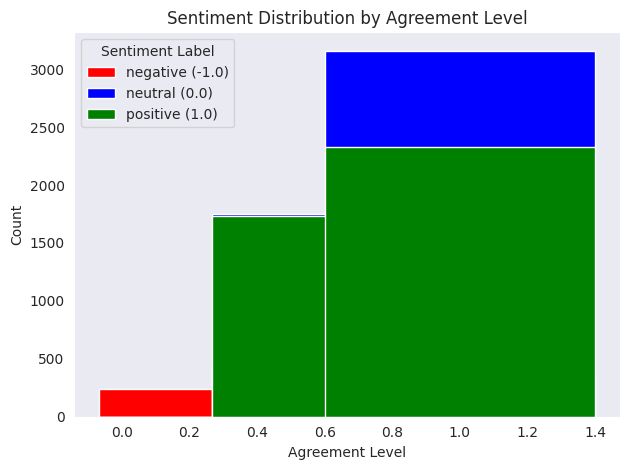

In [27]:
# Counting the sentiment labels within each agreement level category
label_counts = df.groupby(['agreement', 'label']).size().unstack()

# Plotting the distribution
fig, ax = plt.subplots()
agreement_levels = label_counts.index
labels = label_counts.columns
colors = ['red', 'blue', 'green']
sentiment_labels = ['negative', 'neutral', 'positive']

for i, sentiment_label in enumerate(labels):
    counts = label_counts[sentiment_label].fillna(0)
    ax.bar(agreement_levels, counts, label=f'{sentiment_labels[i]} ({sentiment_label})', color=colors[i])

ax.set_xlabel('Agreement Level')
ax.set_ylabel('Count')
ax.legend(title='Sentiment Label')

plt.title('Sentiment Distribution by Agreement Level')
plt.tight_layout()
plt.show()

The plot shows the aggregates of the sentiment labels based on the agreement level using the groupby function and showing the distribution. Each sentiment label is represented by a different color, and the legend indicates the corresponding sentiment label.

###  Analyze the association between the sentiment labels and multiple keywords "measle", "measles", "vaccine", "vaccines", "vaccination", and "health"

The code below adds two new columns, 'measles_combined' and 'vaccines_combined', to the train_df DataFrame, which contain the combined occurrences of 'measle' and 'measles', and 'vaccine' and 'vaccines', respectively. The keywords_updated list is also updated to include these combined columns. The keyword_frequencies DataFrame is then calculated based on the updated keywords.

In [28]:
# make a copy of df
df_edit = copy.deepcopy(df)

In [29]:
# Create keyword columns
keywords = ['measle', 'measles', 'vaccine', 'vaccines', 'vaccination', 'health']
for keyword in keywords:
    df_edit[keyword] = df_edit['safe_text'].str.contains(keyword, case=False).astype(int)

# Combine occurrences of 'measle' and 'measles'
df_edit['measles_combined'] = df_edit['measle'] + df_edit['measles']

# Combine occurrences of 'vaccine' and 'vaccines'
df_edit['vaccines_combined'] = df_edit['vaccine'] + df_edit['vaccines']

# Update the keyword list
keywords_updated = ['measles_combined', 'vaccines_combined', 'vaccination', 'health']

# Group the data by sentiment label and calculate keyword frequencies
keyword_frequencies = df_edit.groupby('label')[keywords_updated].sum()

# Print the keyword frequencies
keyword_frequencies

,measles_combined,vaccines_combined,vaccination,health
label,,,,
-1.0,210,968,145,70
0.0,4588,1104,298,705
1.0,1875,2406,606,431


### Keyword Frequencies by Sentiment Label
The chart allows us to compare the distribution and relative frequencies of keywords across different sentiment categories.

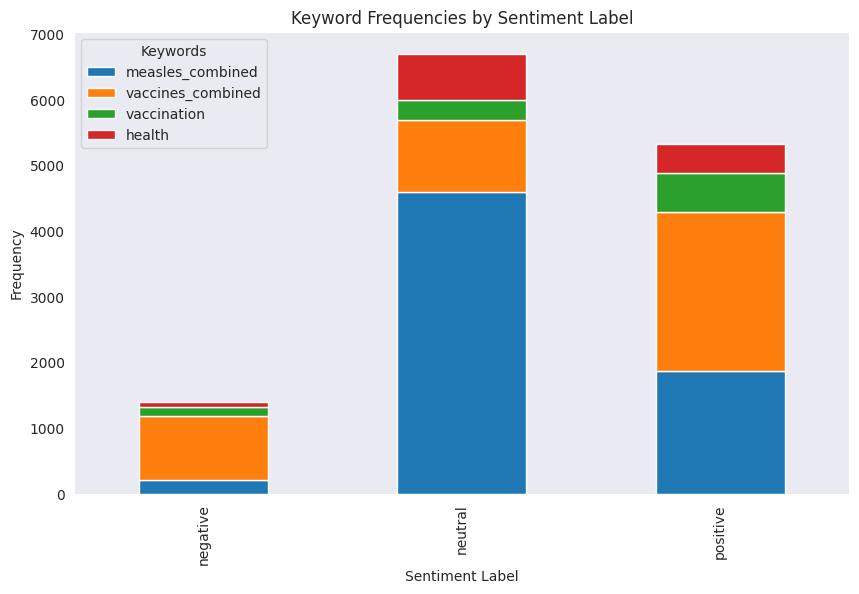

In [30]:
# Set the labels for the sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Plot the stacked bar chart
keyword_frequencies.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Keyword Frequencies by Sentiment Label')

# Show the legend
plt.legend(title='Keywords')

# Set the x-axis tick labels as the sentiment labels
plt.xticks(range(len(sentiment_labels)), sentiment_labels)

# Show the plot
plt.show()

From the plot, we cann summarize that:
- The words "measle(s)" are used most (over 4500 times) in the **neutral** sentiment label followed 2nd by "vaccine(s)" and 3rd by word "health".
- The words "vaccine(s)" are used most (about 2000 times) in the **positive** sentiment label followed 2nd by "measle(s)" and 3rd by word "vacciation".
- The words "vaccine(s)" are used most (about 1000 times) in the **negative** sentiment label followed 2nd by "measle(s)" and 3rd by word "vacciation".

## Data Preprocessing
In the above-given problem statement, before training the model, removing special characters like emojis, hashtags, etc. The text document is then converted into lowercase for better generalization.

Subsequently, the punctuations were cleaned and removed, thereby reducing the unnecessary noise from the dataset. After that, we also removed the repeating characters from the words along with removing the URLs as they do not have any significant importance.

At last, we then performed Stemming(reducing the words to their derived stems) and Lemmatization(reducing the derived words to their root form, known as lemma) for better results.

In [31]:
#Making statement text in lowercase

df['safe_text']=df['safe_text'].str.lower()
df['safe_text']

0        me &amp; the big homie meanboy3000 #meanboy #m...
1        i'm 100% thinking of devoting my career to pro...
2        #whatcausesautism vaccines, do not vaccinate y...
3        i mean if they immunize my kid with something ...
4        thanks to <> catch me performing at la nuit ny...
                               ...                        
9996     living in a time where the sperm i used to was...
9997     <> <>  in spite of all measles outbreaks, judg...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine: for women w risk of pulmona...
Name: safe_text, Length: 9999, dtype: object

In [32]:
# Cleaning and removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['safe_text']= df['safe_text'].apply(lambda x: cleaning_punctuations(x))
df['safe_text']

0        me amp the big homie meanboy3000 meanboy mb mb...
1        im 100 thinking of devoting my career to provi...
2        whatcausesautism vaccines do not vaccinate you...
3        i mean if they immunize my kid with something ...
4        thanks to  catch me performing at la nuit nyc ...
                               ...                        
9996     living in a time where the sperm i used to was...
9997        in spite of all measles outbreaks judge in ...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine for women w risk of pulmonar...
Name: safe_text, Length: 9999, dtype: object

In [33]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['safe_text'] = df['safe_text'].apply(lambda x: cleaning_repeating_char(x))
df['safe_text']

0        me amp the big homie meanboy3000 meanboy mb mb...
1        im100 thinking of devoting my career to provin...
2        whatcausesautism vaccines do not vaccinate you...
3        i mean if they immunize my kid with something ...
4        thanks to  catch me performing at la nuit nyc1...
                               ...                        
9996     living in a time where the sperm i used to was...
9997        in spite of all measles outbreaks judge in ...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine for women w risk of pulmonar...
Name: safe_text, Length: 9999, dtype: object

In [34]:
# Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['safe_text'] = df['safe_text'].apply(lambda x: cleaning_URLs(x))
df['safe_text']

0        me amp the big homie meanboy3000 meanboy mb mb...
1        im100 thinking of devoting my career to provin...
2        whatcausesautism vaccines do not vaccinate you...
3        i mean if they immunize my kid with something ...
4        thanks to  catch me performing at la nuit nyc1...
                               ...                        
9996     living in a time where the sperm i used to was...
9997        in spite of all measles outbreaks judge in ...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine for women w risk of pulmonar...
Name: safe_text, Length: 9999, dtype: object

In [35]:
# Cleaning and removing numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['safe_text'] = df['safe_text'].apply(lambda x: cleaning_numbers(x))
df['safe_text']

0        me amp the big homie meanboy meanboy mb mbs mm...
1        im thinking of devoting my career to proving a...
2        whatcausesautism vaccines do not vaccinate you...
3        i mean if they immunize my kid with something ...
4        thanks to  catch me performing at la nuit nycs...
                               ...                        
9996     living in a time where the sperm i used to was...
9997        in spite of all measles outbreaks judge in ...
9998     interesting trends in child immunization in ok...
9999     cdc says measles are at highest levels in deca...
10000    pneumonia vaccine for women w risk of pulmonar...
Name: safe_text, Length: 9999, dtype: object

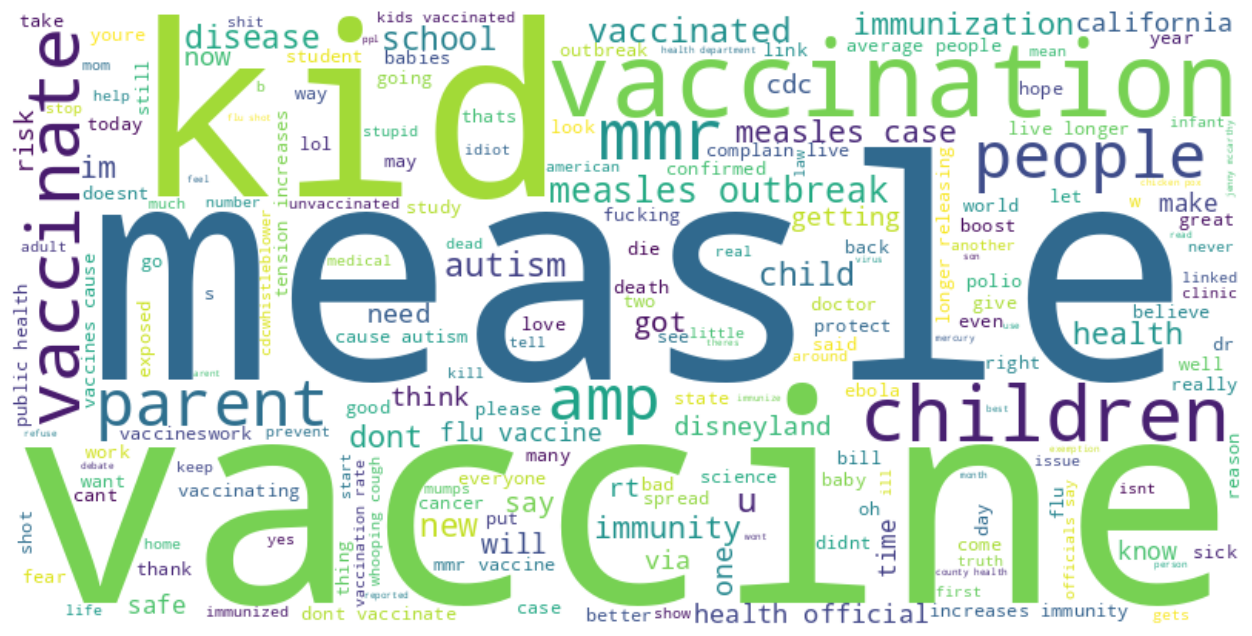

In [36]:
# Generate a word cloud from the message text data
text = " ".join(tweet for tweet in df.safe_text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [37]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [38]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,mickeys measles has gone international,0.0,1.000000
3907,5GV8NEZS,new extends exemption from charitable immunit...,0.0,1.000000
795,EI10PS46,your ignorance on vaccines isnt just dangero...,1.0,0.666667
5793,OM26E6DG,pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,in other news ive gone up like mmr,0.0,1.000000


In [39]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,childrens museum of houston to offer free vacc...,1.0,1.000000
1754,2DD250VN,no i was properly immunized prior to the perf...,1.0,1.000000
3325,ESEVBTFN,thx for posting vaccinations are imperative a...,1.0,1.000000
1485,S17ZU0LC,this baby is exactly why everyone needs to vac...,1.0,0.666667
4175,IIN5D33V,meeting tonight pm in room of the student cen...,1.0,1.000000


In [40]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [41]:
# Save splitted subsets
train.to_csv("../data/train_subset.csv", index=False)
eval.to_csv("../eval_subset.csv", index=False)

In [42]:
dataset = load_dataset('csv',
                        data_files={'train': '../data/train_subset.csv',
                        'eval': '../data/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/penscola/.cache/huggingface/datasets/csv/default-bcc0cc5ebaef6d17/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Tokenize

In [43]:
model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [44]:
#for inspecting the vocabulary size
print('tokenizer vocab size: ',tokenizer.vocab_size)


#Model maximum context size
print('Model max length: ',tokenizer.model_max_length)


# features name - An attribute to know about is the names of the fields that the model expects in its forward pass:
print('Features name: ',tokenizer.model_input_names)

tokenizer vocab size:  30522
Model max length:  512
Features name:  ['input_ids', 'attention_mask']


In [45]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(batch):
    return tokenizer(batch['safe_text'], padding=True, truncation=True)

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True, batch_size=None)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [46]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [47]:
dataset['train'].features['labels']

Value(dtype='int64', id=None)

## Training a Text Classifier - DistilBERT
#### Token Encoding > Token Embedding > Encoder Stack > Hidden states > Classification head > Predictions
## Using Pretrained Model - DistilBERT

In [48]:
model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
torch.cuda.empty_cache()
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy() }

dataset.set_format('torch', columns = ["input_ids", "attention_mask", "labels"] )

pretrained_hidden_states = dataset.map(get_hidden_state, batched=True)

pretrained_hidden_states['train'].column_names

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

In [ ]:
X_train = np.array(pretrained_hidden_states["train"]["hidden_state"])
X_valid = np.array(pretrained_hidden_states['eval']["hidden_state"])

y_train = np.array(pretrained_hidden_states["train"]["labels"])
y_valid = np.array(pretrained_hidden_states["eval"]["labels"])
print(f'Xtrain_shape : {X_train.shape}, X_valid_shape: {X_valid.shape}')

In [ ]:
# in this data hidden state 768 dimensions and featured scale [0,1] interval like MinMaxScale
# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# initialize and fit UMAP
mapper = UMAP(n_components = 2, metric="cosine").fit(X_train_scaled)

# Create a Dataframe of 2D embeddings

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_,columns=["X","Y"])

df_embedded_from_hidden["labels"] = y_train

display(df_embedded_from_hidden.head())

## Training a simple Logistic Classifier

In [ ]:
# Max iteration (3000)
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
print('Logistic Regression_Score',lr_clf.score(X_valid, y_valid))

## Dummy Classifier

In [ ]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_valid, y_valid))

## Fine Tuning

In [ ]:
num_labels = 3

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels ).to(device) )

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

## Training

In [ ]:
batch_size = 12

logging_steps = len(dataset['train']) // batch_size

model_name = f"{model_ckpt}-finetune-tweet"

training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error"
                                  )

In [ ]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = dataset["train"].shuffle(seed=10),
                  eval_dataset = dataset["eval"].shuffle(seed=10),
                  tokenizer = tokenizer
                  )
trainer.train()

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = dataset["train"].shuffle(seed=10),
    eval_dataset = dataset["eval"].shuffle(seed=10),
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation
trainer.evaluate()

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.

In [ ]:
trainer.push_to_hub()